### Importing the necessary libraries for the analysis

In [498]:
import os
import time
import tweepy as tw
from tweepy.errors import HTTPException
import requests as rq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import re
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from wordcloud import WordCloud
from textwrap import wrap

In [466]:
#loading in of the twitter_arch dataset
twitter_arch=pd.read_csv('twitter-archive-enhanced.csv')

In [10]:
#checking the first 5 observations
twitter_arch.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [4]:
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response=rq.get(url)

In [5]:
with open('image_predictions.tsv','wb') as f:
    f.write(response.content)

In [54]:
image=pd.read_table('image_predictions.tsv',sep='\t')

In [4]:
image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [3]:
consumer_key='3vxiGfpYHHUCQeIliQ0OnSoWT'
consumer_secret='8yGfJru1RP0KzehMyRehZvoAX5dlU2ccTebTi8unFiYq2M4cIO'
access_token='1131987082744913926-1p2ZtOY9CiNGJw6aWQcQVrMeGbrZVT'
access_token_secret='Qe9sHhax5XNdmxvpDFySGZRQgS8CS7z4TYeBCgo5YDT6H'

In [4]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [5]:
tweet_id=[]
for tweet in twitter_arch['tweet_id']:
    tweet_id.append(tweet)

In [6]:
with open('tweet_json.txt','w') as D:
    for i_d in tweet_id:
        try:
            json.dump((api.get_status(i_d,tweet_mode='extended')._json),D)
            D.write('\n')
        except HTTPException as e:
                # continue if we are not authourized to access the user's timeline or user doesn't exist anymore or deleted
                if e.response.status_code in (401, 404, 403):
                    continue
                raise e

Rate limit reached. Sleeping for: 178
Rate limit reached. Sleeping for: 183


In [18]:
def data_gathering(data):
    b=[]
    with open(data,"r")as r:
        for line in r:
            t = json.loads(line)
            b.append(t)
    l=[]
    for i in b:
        l.append({"tweet_id":i['id'],
                 "retweet_count":i['retweet_count'],
                 "favorite_count":i['favorite_count'],
                 "retweeted":i['retweeted']})
    return pd.DataFrame(l)
    

In [19]:
tweet=data_gathering("tweet_json.txt")

In [21]:
tweet.head()

,tweet_id,retweet_count,favorite_count,retweeted
0,892420643555336193,6976,33701,False
1,892177421306343426,5280,29231,False
2,891815181378084864,3466,21972,False
3,891689557279858688,7190,36778,False
4,891327558926688256,7723,35166,False


In [509]:
tweet.shape

(2327, 4)

In [50]:
twitter_arch.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [23]:
twitter_arch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [24]:
twitter_arch.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [116]:
((twitter_arch.isnull().sum())/len(twitter_arch))*100

tweet_id                       0.000000
in_reply_to_status_id         96.689304
in_reply_to_user_id           96.689304
timestamp                      0.000000
source                         0.000000
text                           0.000000
retweeted_status_id           92.317487
retweeted_status_user_id      92.317487
retweeted_status_timestamp    92.317487
expanded_urls                  2.504244
rating_numerator               0.000000
rating_denominator             0.000000
name                           0.000000
doggo                          0.000000
floofer                        0.000000
pupper                         0.000000
puppo                          0.000000
dtype: float64

In [46]:
twitter_arch.duplicated().sum()

0

In [52]:
twitter_arch['name'].describe()

count     2356
unique     957
top       None
freq       745
Name: name, dtype: object

In [66]:
image.head(11)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [56]:
image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [57]:
((image.isnull().sum())/len(image))*100

tweet_id    0.0
jpg_url     0.0
img_num     0.0
p1          0.0
p1_conf     0.0
p1_dog      0.0
p2          0.0
p2_conf     0.0
p2_dog      0.0
p3          0.0
p3_conf     0.0
p3_dog      0.0
dtype: float64

In [59]:
image.duplicated().sum()

0

In [61]:
image.tweet_id.describe()

count    2.075000e+03
mean     7.384514e+17
std      6.785203e+16
min      6.660209e+17
25%      6.764835e+17
50%      7.119988e+17
75%      7.932034e+17
max      8.924206e+17
Name: tweet_id, dtype: float64

In [62]:
tweet.head()

,tweet_id,retweet_count,favorite_count,retweeted
0,892420643555336193,6976,33701,False
1,892177421306343426,5280,29231,False
2,891815181378084864,3466,21972,False
3,891689557279858688,7190,36778,False
4,891327558926688256,7723,35166,False


In [63]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2327 non-null   int64
 1   retweet_count   2327 non-null   int64
 2   favorite_count  2327 non-null   int64
 3   retweeted       2327 non-null   bool 
dtypes: bool(1), int64(3)
memory usage: 56.9 KB


In [64]:
tweet.describe()

,tweet_id,retweet_count,favorite_count
count,2.327000e+03,2327.000000,2327.000000
mean,7.417930e+17,2460.501074,7027.513107
std,6.820795e+16,4167.087429,10918.990892
min,6.660209e+17,1.000000,0.000000
25%,6.781394e+17,492.500000,1221.000000
50%,7.178418e+17,1146.000000,3039.000000
75%,7.986547e+17,2846.000000,8566.500000
max,8.924206e+17,70400.000000,144275.000000


In [65]:
tweet.retweeted.nunique()

1

In [67]:
((tweet.isnull().sum())/len(tweet))*100

tweet_id          0.0
retweet_count     0.0
favorite_count    0.0
retweeted         0.0
dtype: float64

### Data Cleaning

### Quality issue
#### twitter_arch Table
- presence of null values in most of the columns
- outliers in the rating numerator column
- outliers in the rating denominator column
- url embedded in the text
- timestamp column is object data type not datetime
- inconsistent dog name

#### Image table
- inappropriate feature naming
- presence of non-dog observations

### Tidiness issues
- image prediction variable spread over multiple columns
- Dog variable spread over multiple table
- Dog stages spread over multiple columns

Removal of null values from the twitter_arch table

In [467]:
#making a copy of the original dataset before data cleaning
twitter_arch_d=twitter_arch.copy()

In [468]:
#Checking and Eliminating columns with more than 15% of null values
excess_columns=twitter_arch.columns[(twitter_arch.isna().sum()/len(twitter_arch.index)*100)>15]
twitter_arch=twitter_arch.loc[:,~(twitter_arch.columns.isin(excess_columns))]

In [469]:
((twitter_arch.isnull().sum())/len(twitter_arch))*100

tweet_id              0.000000
timestamp             0.000000
source                0.000000
text                  0.000000
expanded_urls         2.504244
rating_numerator      0.000000
rating_denominator    0.000000
name                  0.000000
doggo                 0.000000
floofer               0.000000
pupper                0.000000
puppo                 0.000000
dtype: float64

In [470]:
#dropping the expanded_url column since is not useful for further analysis
twitter_arch.drop(columns='expanded_urls',inplace=True,axis=0)

In [471]:
((twitter_arch.isnull().sum())/len(twitter_arch))*100

tweet_id              0.0
timestamp             0.0
source                0.0
text                  0.0
rating_numerator      0.0
rating_denominator    0.0
name                  0.0
doggo                 0.0
floofer               0.0
pupper                0.0
puppo                 0.0
dtype: float64

Removal of outliers from twitter_arch table (inconstitent values from the rating numerator and rating denominator column)

In [472]:
#checking the proportion of rating_denominator with a value greater than 10
len(twitter_arch[twitter_arch['rating_denominator']>10])

20

In [473]:
#checking the proportion of rating_denominator with a value less than 10
len(twitter_arch[twitter_arch['rating_denominator']<10])

3

In [474]:
#checking the proportion of rating_denominator with a value greater than 20
len(twitter_arch[twitter_arch['rating_numerator']>20])

24

In [475]:
#eliminating the rows with rating denominator greater than or less than 10
twitter_arch=twitter_arch[~((twitter_arch['rating_denominator']>10) | (twitter_arch['rating_denominator']<10))]

In [476]:
#eliminating the rows with rating numerator greater than 20
twitter_arch=twitter_arch[~(twitter_arch['rating_numerator']>20)]

Giving the proportion of the rows that contain a value less than and greater than 10 for rating denominator, it advisable to drop the rows in other not to affect the integrity of the result, giving that 10 is the logical value that can be used for rating denominator. Also a numerator value greater than 20 is also consider extreme(outliers) considering other values and should also be removed


In [129]:
twitter_arch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2324 non-null   int64 
 1   timestamp           2324 non-null   object
 2   source              2324 non-null   object
 3   text                2324 non-null   object
 4   rating_numerator    2324 non-null   int64 
 5   rating_denominator  2324 non-null   int64 
 6   name                2324 non-null   object
 7   doggo               2324 non-null   object
 8   floofer             2324 non-null   object
 9   pupper              2324 non-null   object
 10  puppo               2324 non-null   object
dtypes: int64(3), object(8)
memory usage: 217.9+ KB


In [228]:
twitter_arch.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None


Removing the dog stages columnns since majority of the value are none and can not be use for further analysis

In [477]:
#dropping the dog stages columns
twitter_arch.drop(columns=['doggo','floofer','pupper','puppo'], inplace=True)

In [478]:
#converting the timestamp to datetime data type
twitter_arch['timestamp']= pd.to_datetime(twitter_arch['timestamp'])

In [479]:
#checking the maximum date of the tweet to see if there is any tweet beyond 01/08/2017
max(twitter_arch['timestamp'])

Timestamp('2017-08-01 16:23:56+0000', tz='UTC')

#### Text Cleaning

In [482]:
#removing the url,special character and numbers from the text
twitter_arch['text']=twitter_arch['text'].apply(lambda x:x.lower())
twitter_arch['text']=twitter_arch['text'].apply(lambda x:re.sub(r'https://t.co/[a-zA-Z0-9]*$','',x))
twitter_arch['text']=twitter_arch['text'].apply(lambda x:re.sub(r'\s+https://t.co/[a-zA-Z0-9]*\s','',x))
twitter_arch['text']=twitter_arch['text'].apply(lambda x:re.sub(r'https://t.co/[a-zA-Z0-9]*$','',x))
twitter_arch['text']=twitter_arch['text'].apply(lambda x:re.sub(r'[^A-Za-z]+',' ',x))


In [483]:
twitter_arch['text'][9]

'this is cassie she is a college pup studying international doggo communication and stick theory so elegant much sophisticate '

In [273]:
image.head(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [268]:
image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [269]:
image.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [265]:
#making the copy of the original dataset before cleaning
image_d=image.copy()

In [266]:
#checking of duplicates value
len(image_d[image['tweet_id'].duplicated()])

0

In [332]:
#converting the prediction columns into a single variable
image_new=pd.melt(image_d,id_vars=['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_dog'],value_vars=['p1_conf','p2_conf','p3_conf'])

In [271]:
image_new.head(20)

,tweet_id,jpg_url,img_num,p1,p1_dog,variable,value
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,True,p1_conf,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,True,p1_conf,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,True,p1_conf,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,True,p1_conf,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,True,p1_conf,0.560311
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,True,p1_conf,0.651137
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,False,p1_conf,0.933012
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,True,p1_conf,0.692517
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,False,p1_conf,0.962465
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,True,p1_conf,0.201493


In [333]:
#removing non-dog observations
image_new=image_new[~(image_new['p1_dog']==False)]

In [334]:
image_new.rename(columns={'p1':'dog_breed','p1_dog':'dog','variable':'prediction','value':'confidence_level'},inplace=True)

In [337]:
#Extracting the dog prediction dataset with a confidence level of 0.47 and above
images_new=image_new[(image_new['dog']==True)&(image_new['confidence_level']>=0.47)]

In [338]:
images_new

,tweet_id,jpg_url,img_num,dog_breed,dog,prediction,confidence_level
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,True,p1_conf,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,True,p1_conf,0.596461
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,True,p1_conf,0.560311
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,True,p1_conf,0.651137
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,True,p1_conf,0.692517
...,...,...,...,...,...,...,...
2065,890240255349198849,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1,Pembroke,True,p1_conf,0.511319
2066,890609185150312448,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1,Irish_terrier,True,p1_conf,0.487574
2067,890729181411237888,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,Pomeranian,True,p1_conf,0.566142
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,True,p1_conf,0.555712


In [321]:
len(images_new[images_new['tweet_id'].duplicated()])

0

In [502]:
#eliminating excess columns not required for further analysis
images_new.drop(columns=['img_num','dog','prediction'],inplace=True)

In [341]:
images_new

,tweet_id,jpg_url,dog_breed,confidence_level
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,Bernese_mountain_dog,0.651137
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,chow,0.692517
...,...,...,...,...
2065,890240255349198849,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,Pembroke,0.511319
2066,890609185150312448,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,Irish_terrier,0.487574
2067,890729181411237888,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,Pomeranian,0.566142
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712


In [327]:
tweet.describe()

,tweet_id,retweet_count,favorite_count
count,2.327000e+03,2327.000000,2327.000000
mean,7.417930e+17,2460.501074,7027.513107
std,6.820795e+16,4167.087429,10918.990892
min,6.660209e+17,1.000000,0.000000
25%,6.781394e+17,492.500000,1221.000000
50%,7.178418e+17,1146.000000,3039.000000
75%,7.986547e+17,2846.000000,8566.500000
max,8.924206e+17,70400.000000,144275.000000


Merging of the 3 tables together to produce a single table

In [486]:
#merging of the tweet and tweet_arch table to produce a new table master_df
master_df=pd.merge(tweet,twitter_arch,on='tweet_id')


In [487]:
master_df

,tweet_id,retweet_count,favorite_count,retweeted,timestamp,source,text,rating_numerator,rating_denominator,name
0,892420643555336193,6976,33701,False,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",this is phineas he s a mystical boy only ever ...,13,10,Phineas
1,892177421306343426,5280,29231,False,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",this is tilly she s just checking pup on you h...,13,10,Tilly
2,891815181378084864,3466,21972,False,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",this is archie he is a rare norwegian pouncing...,12,10,Archie
3,891689557279858688,7190,36778,False,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",this is darla she commenced a snooze mid meal ...,13,10,Darla
4,891327558926688256,7723,35166,False,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",this is franklin he would like you to stop cal...,12,10,Franklin
...,...,...,...,...,...,...,...,...,...,...
2291,666049248165822465,36,88,False,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" r...",here we have a st generation vulpix enjoys swe...,5,10,None
2292,666044226329800704,115,245,False,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" r...",this is a purebred piers morgan loves to netfl...,6,10,a
2293,666033412701032449,36,100,False,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",here is a very happy pup big fan of well maint...,9,10,a
2294,666029285002620928,39,112,False,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",this is a western brown mitsubishi terrier ups...,7,10,a


In [488]:
master_dfs=pd.merge(master_df,images_new,on='tweet_id')

In [489]:
master_dfs

,tweet_id,retweet_count,favorite_count,retweeted,timestamp,source,text,rating_numerator,rating_denominator,name,jpg_url,dog_breed,confidence_level
0,891815181378084864,3466,21972,False,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",this is archie he is a rare norwegian pouncing...,12,10,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012
1,891327558926688256,7723,35166,False,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",this is franklin he would like you to stop cal...,12,10,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712
2,890729181411237888,15693,56636,False,2017-07-28 00:22:40+00:00,"<a href=""http://twitter.com/download/iphone"" r...",when you watch your owner call another dog a g...,13,10,None,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,Pomeranian,0.566142
3,890609185150312448,3605,24436,False,2017-07-27 16:25:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",this is zoey she doesn t want to be one of the...,13,10,Zoey,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,Irish_terrier,0.487574
4,890240255349198849,6075,27846,False,2017-07-26 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",this is cassie she is a college pup studying i...,14,10,Cassie,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,Pembroke,0.511319
...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,666055525042405380,196,367,False,2015-11-16 00:49:46+00:00,"<a href=""http://twitter.com/download/iphone"" r...",here is a siberian heavily armored polar bear ...,10,10,a,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,chow,0.692517
988,666050758794694657,50,115,False,2015-11-16 00:30:50+00:00,"<a href=""http://twitter.com/download/iphone"" r...",this is a truly beautiful english wilson staff...,10,10,a,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,Bernese_mountain_dog,0.651137
989,666049248165822465,36,88,False,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" r...",here we have a st generation vulpix enjoys swe...,5,10,None,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311
990,666033412701032449,36,100,False,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",here is a very happy pup big fan of well maint...,9,10,a,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461


In [490]:
#creating the rating column
master_dfs['rating']=master_dfs['rating_numerator']/master_dfs['rating_denominator']

In [508]:
#saving the master_dfs to a CSV file
master_dfs.to_csv("twitter_archive_master.csv",index=False)

### Data Analysis
These analysis set answer the following questions;
- what dog breed has the highest number of rating
- what dog brred is the most rated 
- what dog brred elicited the most disagreement among raters 
- is there a relationship between the retweet count, favorites count(likes) and the dog rating


The merged table master_dfs is used for the analysis

In [405]:
master_dfs.describe()

,tweet_id,retweet_count,favorite_count,rating_numerator,rating_denominator,confidence_level,rating
count,9.920000e+02,992.000000,992.000000,992.000000,992.0,992.000000,992.000000
mean,7.466552e+17,2526.727823,8391.136089,11.062500,10.0,0.766505,1.106250
std,6.930768e+16,4292.491011,11925.613885,1.610424,0.0,0.164494,0.161042
min,6.660293e+17,30.000000,0.000000,2.000000,10.0,0.470162,0.200000
25%,6.808677e+17,588.000000,1821.500000,10.000000,10.0,0.615549,1.000000
50%,7.305003e+17,1358.500000,4143.500000,11.000000,10.0,0.778081,1.100000
75%,8.031374e+17,3001.000000,10629.750000,12.000000,10.0,0.919744,1.200000
max,8.918152e+17,70400.000000,144275.000000,14.000000,10.0,0.999956,1.400000


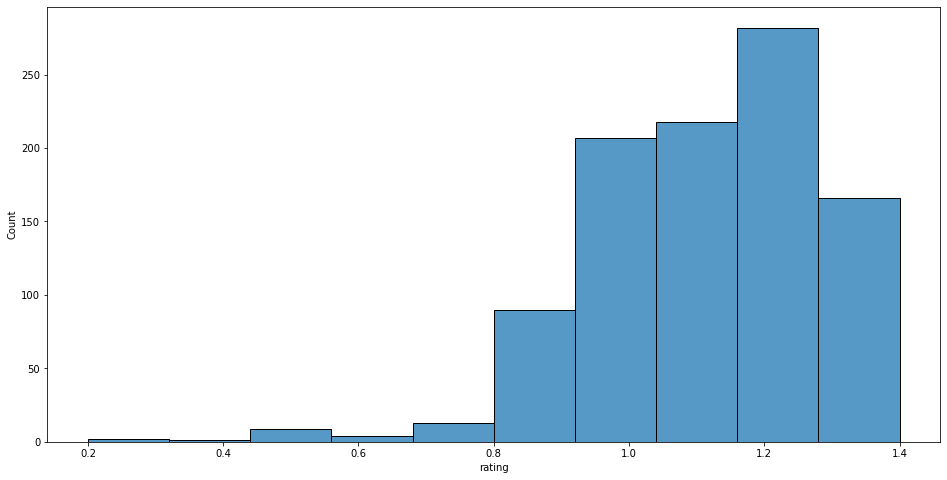

In [401]:
#checking the distribution of the rating
plt.figure(figsize=(16,8))
sns.histplot(data=master_dfs,x="rating", bins=10);

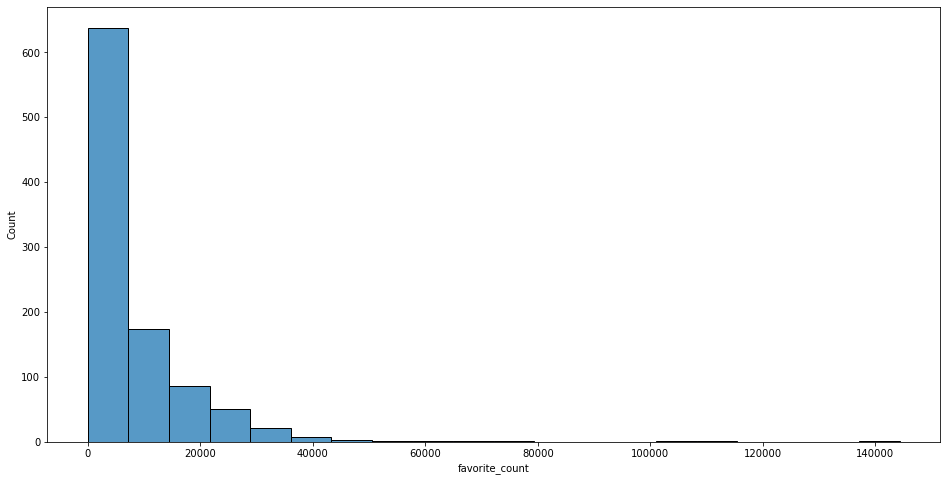

In [403]:
#checking the distribution of the rating
plt.figure(figsize=(16,8))
sns.histplot(data=master_dfs,x="favorite_count", bins=20);

In [395]:
#Extracting the breed of dog with atleast 5 rating
df1=master_dfs.groupby(['dog_breed']).agg(Rate_count=('dog_breed','count'),Mean_rating=('rating',np.mean)).sort_values(by='Rate_count', ascending=False)[:53]
df1.reset_index(inplace=True)

In [436]:
# top 10 most rated dogs
df1.sort_values(by='Rate_count', ascending=False)[:10]

,dog_breed,Rate_count,Mean_rating
0,golden_retriever,126,1.159524
1,Pembroke,72,1.162500
2,Labrador_retriever,69,1.118841
3,Chihuahua,49,1.061224
4,pug,46,1.019565
5,Samoyed,33,1.181818
6,Pomeranian,30,1.120000
7,chow,28,1.171429
8,toy_poodle,26,1.123077
9,French_bulldog,21,1.119048


In [396]:
#top 10 dog breed with the highest rating
df1.sort_values(by='Mean_rating', ascending=False)[:10]

,dog_breed,Rate_count,Mean_rating
22,Eskimo_dog,10,1.190000
5,Samoyed,33,1.181818
7,chow,28,1.171429
13,Cardigan,14,1.164286
1,Pembroke,72,1.162500
0,golden_retriever,126,1.159524
12,cocker_spaniel,16,1.150000
29,Siberian_husky,9,1.144444
26,basset,9,1.144444
32,Old_English_sheepdog,8,1.137500


In [397]:
#Extracting the breed of dog with atleast 5 rating
df2=master_dfs.groupby(['dog_breed']).agg(Rate_count=('dog_breed','count'),STD=('rating',np.std)).sort_values(by='Rate_count', ascending=False)[:53]
df2.reset_index(inplace=True)

In [398]:
# dog breed that elicited the most disagreement among raters
df2.sort_values(by='STD', ascending=False)[:10]

,dog_breed,Rate_count,STD
48,Boston_bull,5,0.270185
36,flat-coated_retriever,7,0.257275
42,borzoi,6,0.240139
14,Maltese_dog,14,0.234052
16,miniature_pinscher,12,0.208167
27,Pekinese,9,0.206155
23,dalmatian,10,0.202485
52,English_setter,5,0.194936
4,pug,46,0.190461
3,Chihuahua,49,0.190193


In [510]:
# checking the correlation between numerical variable
df3=master_dfs[['retweet_count','favorite_count','confidence_level','rating']].corr()

In [511]:
df3

,retweet_count,favorite_count,confidence_level,rating
retweet_count,1.000000,0.872124,-0.016889,0.308090
favorite_count,0.872124,1.000000,-0.000265,0.407506
confidence_level,-0.016889,-0.000265,1.000000,0.023736
rating,0.308090,0.407506,0.023736,1.000000


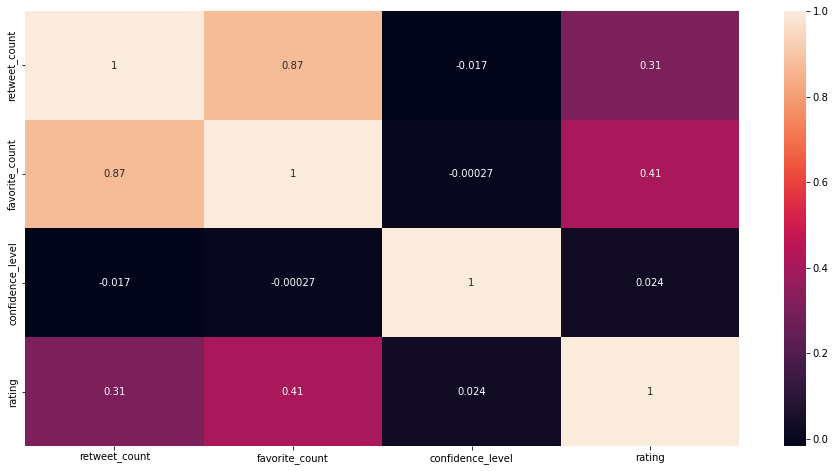

In [514]:
plt.figure(figsize=(16,8))
sns.heatmap(df3,annot=True);

### 

A correlation table showing the relationship between retweet count, favorite count(likes), rating and image confidence level. It can be seen that there is a strong correlation between the retweet count and likes, which shows tweet with high retweet count tends to have more likes. There is also a weak relationship between viewers rating and the amount of likes a tweet got, this shows that the amount of likes a tweet has is not a major determinant of it rating.

### Visualization

In [433]:
#function for plotting a bar-chart
def bar_chart(data,x,y):
    top_10_breed=data.nlargest(10,y)
    top_10_breed=top_10_breed.sort_values(by=y,ascending=False)
    plt.figure(figsize=(17,6))
    ax=sns.barplot(x,y, data=top_10_breed)
    sns.despine()

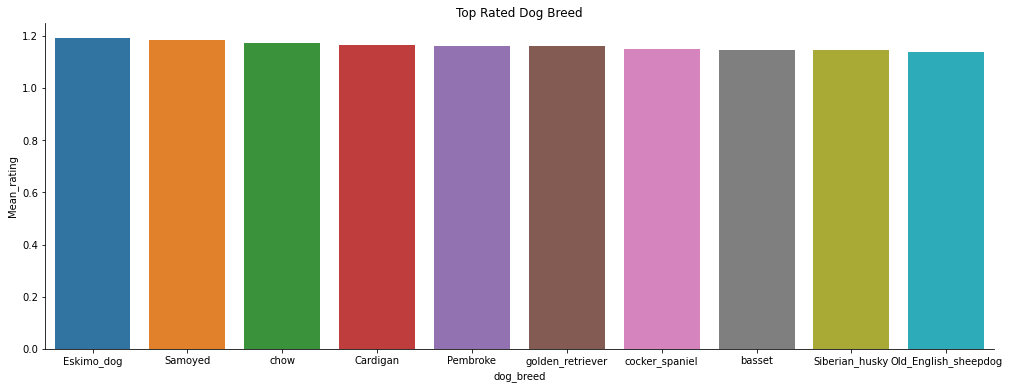

In [500]:
#chart for the top 10 rated dog_breed
bar_chart(df1,'dog_breed','Mean_rating')
ax.set(ylabel='Mean_Ratings')
plt.title("Top Rated Dog Breed");

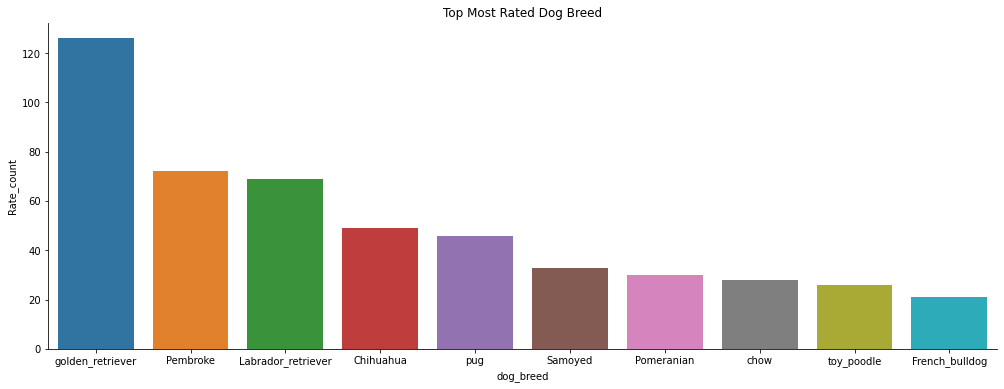

In [501]:
#chart for the top 10 most rated dog_breed
bar_chart(df1,'dog_breed','Rate_count')
ax.set(ylabel='Rate_count')
plt.title("Top Most Rated Dog Breed");

In [495]:
master_dfs['text']=master_dfs['text'].apply(lambda x:' '.join([w for w in x.split() if len(w)>=3]))

In [496]:
allword=' '.join([text for text in master_dfs['text']])

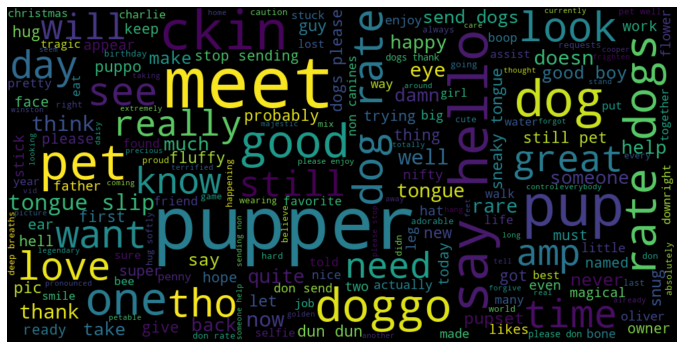

In [497]:
#chart showing the most frequently used word in all tweet text
wordcloud = WordCloud(width=1000, height=500, random_state=21, max_font_size=110).generate(allword)
plt.figure(figsize=(12,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');